## Setup environment

In [ ]:
!pip install pandas

In [ ]:
import os, subprocess, pandas as pd

# --- Detect your username automatically ---
username = os.getenv("USER") or os.getenv("USERNAME") or "qmedasia"

print(f"Detected username: {username}")

# --- Get all GPU processes from nvidia-smi ---
cmd = "nvidia-smi --query-compute-apps=pid,process_name,used_gpu_memory --format=csv,noheader,nounits"
output = subprocess.check_output(cmd, shell=True).decode().strip().split("\n")

processes = []
for line in output:
    parts = [p.strip() for p in line.split(",")]
    if len(parts) == 3:
        pid, name, mem = parts
        # Only include processes owned by the user
        try:
            proc_user = subprocess.check_output(f"ps -o user= -p {pid}", shell=True).decode().strip()
            if proc_user == username:
                processes.append({"PID": pid, "Process": name, "GPU Memory (MB)": int(mem)})
        except:
            pass

df = pd.DataFrame(processes)

if df.empty:
    print("No GPU processes belonging to you.")
else:
    print("\nKilling your GPU processes...")
    display(df)

    # Kill them all
    for pid in df["PID"]:
        try:
            subprocess.call(f"kill -9 {pid}", shell=True)
            print(f"Killed PID {pid}")
        except Exception as e:
            print(f"Error killing {pid}: {e}")

    print("\nDone. Run nvidia-smi to verify.")

In [ ]:
# Set the environment variable to allow duplicate OpenMP libraries
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[ignite, tqdm, tensorboard]"

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
!pip install lightning matplotlib tensorboard

/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)


## Setup Import

In [4]:
import requests
import zipfile
from pathlib import Path
from collections import Counter

import os
import csv
import logging
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityD, ResizeD, RandZoomD
from monai.networks.nets import densenet121, resnet50, EfficientNetBN
from IPython.display import display


## Download Dataset

In [5]:
def download_and_unzip(url, extract_path):
    # Download the ZIP file
    response = requests.get(url, stream=True)
    with open('temp.zip', 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:  # filter out keep-alive new chunks
                file.write(chunk)

    # Unzip the downloaded file
    with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Remove the temporary ZIP file
    import os
    os.remove('temp.zip')

# Example usage:
url = "https://wistify.b-cdn.net/website-resources/DR_short.zip"
extract_path = "unzipped_files"
download_and_unzip(url, extract_path)

# change root path
root_dir = Path("unzipped_files")
print(root_dir)

unzipped_files


## Set dataset root directory

In [6]:
# Set logging
logging.basicConfig(level=logging.INFO)

# Function to generate data list dynamically
def generate_data_list(root_dir, section):
    """
    Generate a list of dictionaries for each data sample, including the filename and label.
    """
    data_list = []
    section_dir = os.path.join(root_dir, section)
    if not os.path.isdir(section_dir):
        raise ValueError(f"Section directory {section_dir} does not exist.")
    for grade_folder in sorted(os.listdir(section_dir)):
        grade_path = os.path.join(section_dir, grade_folder)
        if os.path.isdir(grade_path):
            label = int(grade_folder.split("_")[1])  # Extract label from folder name
            for image_file in sorted(os.listdir(grade_path)):
                if image_file.endswith(".png"):
                    image_path = os.path.join(grade_path, image_file)
                    data_list.append({"image": image_path, "label": label, "filename": image_file})
    return data_list


# Root directory for dataset
root_dir = "unzipped_files/DR"

# Load data
train_data_list = generate_data_list(root_dir, "train")
val_data_list = generate_data_list(root_dir, "val")
test_data_list = generate_data_list(root_dir, "test")

all_labels = sorted({item["label"] for item in (train_data_list + val_data_list + test_data_list)})
if not all_labels:
    raise ValueError("No samples found. Please download the dataset before continuing.")
label_to_name = {label: f"Grade_{label}" for label in all_labels}
class_names = [label_to_name[label] for label in all_labels]
num_classes = len(class_names)

print(f"Detected classes: {class_names}")


Detected classes: ['Grade_0', 'Grade_1', 'Grade_2', 'Grade_3', 'Grade_4']


## Dataset EDA

Inspect the split sizes, per-grade distribution, and a few representative samples.

In [ ]:
split_data = {
    "Train": train_data_list,
    "Validation": val_data_list,
    "Test": test_data_list,
}

grade_labels = sorted({item["label"] for data in split_data.values() for item in data})
if not grade_labels:
    raise ValueError("No samples are available for EDA. Please verify the dataset download.")

split_stats = {}
for split_name, data in split_data.items():
    counts = Counter(item["label"] for item in data)
    split_stats[split_name] = {"total": len(data), "counts": counts}
    print(f"{split_name} samples: {len(data)}")

for split_name, stats in split_stats.items():
    print(f"\n{split_name} grade distribution:")
    for label in grade_labels:
        label_name = label_to_name.get(label, f"Grade_{label}")
        print(f"  {label_name}: {stats['counts'].get(label, 0)} images")

fig, axes = plt.subplots(1, len(split_stats), figsize=(5 * len(split_stats), 4), sharey=True)
if len(split_stats) == 1:
    axes = [axes]
for ax, (split_name, stats) in zip(axes, split_stats.items()):
    positions = list(range(len(grade_labels)))
    values = [stats["counts"].get(label, 0) for label in grade_labels]
    ax.bar(positions, values, color="#1f77b4")
    ax.set_title(f"{split_name} per-grade count")
    ax.set_ylabel("Number of images")
    ax.set_xticks(positions)
    ax.set_xticklabels([label_to_name.get(label, f"Grade_{label}") for label in grade_labels], rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, len(grade_labels), figsize=(4 * len(grade_labels), 4))
if len(grade_labels) == 1:
    axes = [axes]
for ax, label in zip(axes, grade_labels):
    sample = next((item for item in train_data_list if item["label"] == label), None)
    ax.axis("off")
    display_name = label_to_name.get(label, f"Grade_{label}")
    if sample is None:
        ax.set_title(f"{display_name}\n(no sample)", fontweight="bold")
        continue
    with Image.open(sample["image"]) as img:
        ax.imshow(img)
    ax.set_title(display_name, fontweight="bold")
plt.suptitle("Train split samples by grade", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()

## Check VRAM Usage

In [8]:
# Check initial VRAM usage
initial_vram = torch.cuda.memory_allocated()
print(f"Initial VRAM usage: {initial_vram / 1024**2:.2f} MB")

!nvidia-smi

Initial VRAM usage: 0.00 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 10 09:27:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   31C    P0              53W / 400W |     87MiB / 81920MiB |     N/A      Default |
|                   

## Setup dataloader

In [ ]:
from monai.data import Dataset

# Define transformations
transforms = Compose([
    LoadImageD(keys="image", image_only=True),
    EnsureChannelFirstD(keys="image"),
    ScaleIntensityD(keys="image"),
    ResizeD(keys="image", spatial_size=(256, 256)),
    RandZoomD(keys="image", min_zoom=0.9, max_zoom=1.1, prob=0.5)
])

# Create MONAI datasets
train_dataset = Dataset(data=train_data_list, transform=transforms)
val_dataset = Dataset(data=val_data_list, transform=transforms)
test_dataset = Dataset(data=test_data_list, transform=transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


## Setup Pytorch Lightning Module for Training DR

In [10]:
from torchmetrics.classification import MulticlassAccuracy


def build_backbone(model_name: str, num_classes: int):
    name = model_name.lower()
    if name in {"densenet", "densenet121"}:
        return densenet121(spatial_dims=2, in_channels=3, out_channels=num_classes)
    if name in {"resnet", "resnet50"}:
        return resnet50(spatial_dims=2, n_input_channels=3, num_classes=num_classes)
    if name in {"efficientnet", "efficientnet-b0", "efficientnet_b0"}:
        return EfficientNetBN(model_name="efficientnet-b0", spatial_dims=2, in_channels=3, num_classes=num_classes)
    raise ValueError(f"Unsupported model name: {model_name}")


class DRModel(pl.LightningModule):
    def __init__(self, model_name: str = "densenet121", num_classes: int = 5, lr: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = build_backbone(model_name=model_name, num_classes=num_classes)
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.train_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.val_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.test_accuracy = MulticlassAccuracy(num_classes=num_classes)
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.train_accuracy(outputs, labels)
        self.log("train_loss", loss)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        outputs = self(images)
        loss = self.loss_fn(outputs, labels)
        acc = self.val_accuracy(outputs, labels)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch["image"], batch["label"]
        outputs = self(images)
        acc = self.test_accuracy(outputs, labels)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


## Train multiple backbones and compare performance
- **Training** takes around 5-10 mins. 
- **Changing training parameters (epoch, learning rate)** will slow down the training process.

In [ ]:
model_configs = [
    {"name": "densenet121", "display_name": "DenseNet121"},
    {"name": "resnet50", "display_name": "ResNet50"},
    {"name": "efficientnet-b0", "display_name": "EfficientNet-B0"},
]

learning_rate = 1e-4
max_epochs = 3
model_results = []
best_checkpoints = {}


def _to_float(metric):
    if metric is None:
        return None
    if isinstance(metric, torch.Tensor):
        return float(metric.detach().cpu())
    return float(metric)


for cfg in model_configs:
    print(f"\nTraining {cfg['display_name']}...")
    model = DRModel(model_name=cfg["name"], num_classes=num_classes, lr=learning_rate)
    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=f"./eval/{cfg['name']}",
        filename=f"{cfg['name']}-best",
        save_top_k=1,
        mode="min",
    )
    early_stopping = EarlyStopping(monitor="val_loss", patience=3, mode="min")
    logger = TensorBoardLogger("lightning_logs", name=f"DR_classification_{cfg['name']}")
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices=1,
        logger=logger,
        callbacks=[checkpoint_callback, early_stopping],
        log_every_n_steps=10,
    )
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    ckpt_path = checkpoint_callback.best_model_path if checkpoint_callback.best_model_path else None
    test_metrics = trainer.test(model=model, dataloaders=test_loader, ckpt_path=ckpt_path or None, verbose=False)
    val_acc = trainer.callback_metrics.get("val_acc")
    test_acc = test_metrics[0].get("test_acc") if test_metrics else None

    model_results.append(
        {
            "Model": cfg["display_name"],
            "Backbone": cfg["name"],
            "Val Accuracy": _to_float(val_acc),
            "Test Accuracy": _to_float(test_acc),
        }
    )
    best_checkpoints[cfg["display_name"]] = ckpt_path


Training DenseNet121...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-80GB MIG 3g.40gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Checkpoint directory /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/densenet121 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | DenseNet121        | 7.0 M  | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccu

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 2/2 [00:22<00:00,  0.09it/s, v_num=2, train_acc=0.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:22<00:00,  0.09it/s, v_num=2, train_acc=0.280, val_loss=1.610, val_acc=0.150]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:21<00:00,  0.09it/s, v_num=2, train_acc=0.617, val_loss=1.610, val_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:29<00:00,  0.07it/s, v_num=2, train_acc=0.617, val_loss=1.620, val_acc=0.250]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2/2 [00:29<00:00,  0.07it/s, v_num=2, train_acc=0.617, val_loss=1.620, val_acc=0.250]


Restoring states from the checkpoint path at /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/densenet121/densenet121-best-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/densenet121/densenet121-best-v2.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.15it/s]

Training ResNet50...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/resnet50 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 23.5 M | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.088    Total estimated model params size (MB)
155       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Setting sig

Epoch 0: 100%|██████████| 2/2 [00:22<00:00,  0.09it/s, v_num=1, train_acc=0.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:22<00:00,  0.09it/s, v_num=1, train_acc=0.367, val_loss=1.610, val_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:23<00:00,  0.08it/s, v_num=1, train_acc=0.130, val_loss=1.620, val_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=1, train_acc=0.130, val_loss=1.640, val_acc=0.200]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=1, train_acc=0.130, val_loss=1.640, val_acc=0.200]


Restoring states from the checkpoint path at /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/resnet50/resnet50-best-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/resnet50/resnet50-best-v1.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]

Training EfficientNet-B0...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Checkpoint directory /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/efficientnet-b0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | EfficientNetBN     | 4.0 M  | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.056    Total estimated model params size (MB)
279       Modules in train mode
0         Modules in eval mode
SLURM auto-requeueing enabled. Sett

Epoch 0: 100%|██████████| 2/2 [00:22<00:00,  0.09it/s, v_num=1, train_acc=0.167]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:22<00:00,  0.09it/s, v_num=1, train_acc=0.247, val_loss=3.100, val_acc=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:23<00:00,  0.09it/s, v_num=1, train_acc=0.440, val_loss=3.180, val_acc=0.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=1, train_acc=0.440, val_loss=3.230, val_acc=0.250]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 2/2 [00:31<00:00,  0.06it/s, v_num=1, train_acc=0.440, val_loss=3.230, val_acc=0.250]


Restoring states from the checkpoint path at /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/efficientnet-b0/efficientnet-b0-best-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /scr/user/qmedasia/.bootcamp/monai/nvidia_monai_worksop_1/1_Classification_2D/eval/efficientnet-b0/efficientnet-b0-best-v1.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.67it/s]


,Model,Backbone,Val Accuracy,Test Accuracy
0,DenseNet121,densenet121,None,0.1
1,ResNet50,resnet50,None,0.2
2,EfficientNet-B0,efficientnet-b0,None,0.1


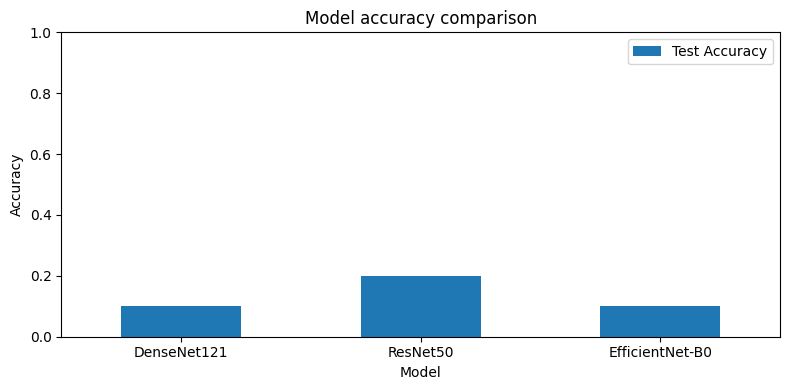

Recommended backbone: DenseNet121 (val acc n/a, test acc 0.1000)


In [12]:
model_performance_df = pd.DataFrame(model_results)
if not model_performance_df.empty:
    model_performance_df = model_performance_df.sort_values(by="Val Accuracy", ascending=False).reset_index(drop=True)
    display(model_performance_df)
    ax = model_performance_df.plot(
        x="Model",
        y=["Val Accuracy", "Test Accuracy"],
        kind="bar",
        figsize=(8, 4),
    )
    ax.set_ylim(0, 1)
    ax.set_ylabel("Accuracy")
    ax.set_title("Model accuracy comparison")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    best_model_row = model_performance_df.iloc[0]
    best_model_summary = {
        "model_label": best_model_row["Model"],
        "backbone": best_model_row["Backbone"],
        "checkpoint": best_checkpoints.get(best_model_row["Model"]),
        "val_accuracy": best_model_row["Val Accuracy"],
        "test_accuracy": best_model_row["Test Accuracy"],
    }
    val_acc_text = (
        f"{best_model_summary['val_accuracy']:.4f}" if best_model_summary["val_accuracy"] is not None else "n/a"
    )
    test_acc_text = (
        f"{best_model_summary['test_accuracy']:.4f}" if best_model_summary["test_accuracy"] is not None else "n/a"
    )
    print(
        f"Recommended backbone: {best_model_summary['model_label']} (val acc {val_acc_text}, test acc {test_acc_text})"
    )
else:
    best_model_summary = None
    print("No models were trained successfully; please review the logs above.")

## Tensorboard to show the training loss and validation loss

- Vist `http://10.11.132.43:8008/` in the browser for the visualization of the tensorboard.

In [13]:
# %reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs --host 0.0.0.0 --port 8008

## Check Final VRAM Usage

In [14]:
final_vram = torch.cuda.max_memory_allocated()
print(f"Final Peak VRAM during training: {final_vram / 1024**2:.2f} MB")

print(f"Current VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

!nvidia-smi

Final Peak VRAM during training: 28174.81 MB
Current VRAM: 397.94 MB
/bin/bash: /app/miniconda/24.11.1/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Mon Nov 10 09:33:22 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   32C    P0              76W / 400W |     87MiB / 81920MiB |   

## Load the best-performing checkpoint and run inference

In [ ]:
if "best_checkpoints" not in globals() or not best_checkpoints:
    raise RuntimeError("Run the training cell first so best_checkpoints are available.")
if "model_configs" not in globals():
    raise RuntimeError("model_configs is missing. Re-run the training configuration cell.")

current_directory = os.getcwd()
image_path = os.path.join(current_directory, "unzipped_files", "DR", "test", "Grade_4", "3b4a5fcbe5e0.png")
print(f"Image path: {image_path}")

device = "cuda" if torch.cuda.is_available() else "cpu"

test_transforms = Compose([
    LoadImageD(keys="image"),
    EnsureChannelFirstD(keys="image"),
    ScaleIntensityD(keys="image"),
    ResizeD(keys="image", spatial_size=(256, 256)),
])

image_data = {"image": image_path}
transformed = test_transforms(image_data)
image_tensor = torch.as_tensor(transformed["image"]).unsqueeze(0).to(device)

In [ ]:
true_label = os.path.basename(os.path.dirname(image_path))
model_predictions = []
for cfg in model_configs:
    display_name = cfg["display_name"]
    backbone = cfg["name"]
    ckpt_path = best_checkpoints.get(display_name)
    if not ckpt_path:
        print(f"Skipping {display_name} because no checkpoint was found. Re-run training for this model if needed.")
        continue
    print(f"Loading {display_name} from {ckpt_path}")
    model = DRModel.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        model_name=backbone,
        num_classes=num_classes,
        lr=learning_rate,
    )
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)
        predicted_class = int(torch.argmax(probs, dim=1).item())
        predicted_label = label_to_name.get(predicted_class, f"Grade_{predicted_class}")
        confidence = float(probs[0, predicted_class].cpu())
    model_predictions.append({
        "model": display_name,
        "backbone": backbone,
        "predicted_class": predicted_class,
        "predicted_label": predicted_label,
        "confidence": confidence,
    })

In [ ]:
if not model_predictions:
    raise RuntimeError("No model predictions were generated. Check that checkpoints exist for each model.")

with Image.open(image_path) as pil_img:
    fig, axes = plt.subplots(1, len(model_predictions), figsize=(5 * len(model_predictions), 4))
    if len(model_predictions) == 1:
        axes = [axes]
    for ax, pred in zip(axes, model_predictions):
        ax.imshow(pil_img)
        ax.axis("off")
        ax.set_title(f"{pred['model']}\n{pred['predicted_label']} ({pred['confidence']:.2f})", fontweight="bold")
    fig.suptitle(f"Per-model predictions (ground truth: {true_label})", y=1.05, fontsize=12, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

for pred in model_predictions:
    print(f"{pred['model']} predicted {pred['predicted_label']} (confidence {pred['confidence']:.4f})")
